In [1]:
'''
Date: 10 Apr 2020

Python version:      3.7
PyTorch version:     1.2.0

@author: Maksim Lavrov

CIFAR10 dataset

VGG16 baseline model
'''

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

from models.VGG16 import *

epsilons = [0, .05, .1, .15, .2, .25, .3]

# ======================================== prepare the dataset ==========================================================================================
mean_cifar10 = [0.485, 0.456, 0.406]   
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 1

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = VGG16().to(device)

# Load the pretrained model
state = torch.load('./models/model_150_89.pth')
model.load_state_dict(state['model'])

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Files already downloaded and verified
CUDA Available:  True


VGG16(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7):

0 plane


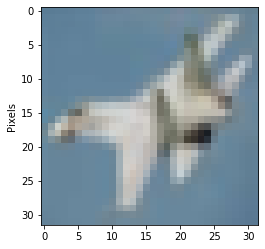

In [2]:
'''  
The image lies between [0,1] but since I have trained the whole network on normalized input, Therefore
the min_val = -2.117 and max_val = 2.64 and not {0,1}
'''
    
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -2.117, 2.64)
    # Return the perturbed image
    return perturbed_image

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        #data, target = data.to(device), target.to(device)
        data, target = data
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)        
        
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

#evaluate model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy on the test dataset is: %f %%' % (
    100 * correct / total))

/home/mlavrov/anaconda3/envs/meng/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 plane 0 epsilon
Epsilon: 0	Test Accuracy = 8934 / 10000 = 0.8934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 plane 0.05 epsilon
Epsilon: 0.05	Test Accuracy = 5580 / 10000 = 0.558


KeyboardInterrupt: 

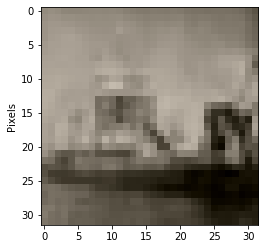

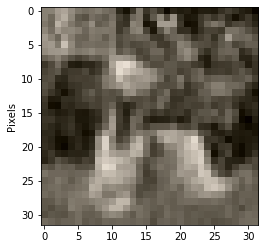

In [3]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Plot several examples of adversarial samples at each epsilon
def convert_cifar10(t,pil):
    """Function to convert a cifar10 image tensor (already normalized)
    onto a plotable image.
    
    :param t: image tensor of size (3,32,23)
    :type t: torch.Tensor
    :param pil: output is of size (3,32,32) if True, else (32,32,3)
    :type pil: bool
    """
    im = torch.tensor(t).clone()
    # approximate unnormalization 
    im[0] = im[0]*0.229 + 0.485
    im[1] = im[1]*0.224 + 0.456
    im[2] = im[2]*0.225 + 0.406
    if not pil:
        im = im.numpy()
        im = np.transpose(im,(1,2,0))
    return im

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        ex = convert_cifar10(ex,pil=False)
        plt.imshow(ex)
        #plt.imshow(np.transpose(ex, (1, 2, 0)), interpolation='nearest')
plt.tight_layout()
plt.show()

#for i, data in enumerate(test_loader, 0):

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    img = img*std.cpu().detach().numpy() + mean.cpu().detach().numpy()     # unnormalize

    npimg = img

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
for epsilon in epsilons:
    data, label = testset[10]
    data.unsqueeze_(0)
    plt.figure()
    plt.ylabel('Pixels')
    imshow(data[0].cpu().detach().numpy())
    print(label, 'plane')
    
    print(data.type())
    data = torch.tensor(data)
    data.requires_grad = True
    data_grad = data.grad
    perturbed_data = fgsm_attack(data, epsilon, data_grad)    

    ############################################
    advs = perturbed_data[0]
    advs = torch.tensor(advs)
    advs.unsqueeze_(0)

    plt.figure()
    plt.ylabel('Pixels')
    imshow(advs[0,0,:].cpu().detach().numpy())
    print(label, 'plane', epsilon, 'epsilon')
    ######################################################